In [63]:
# Paths
db_path = "/home/aelzemity/metalBindPredict/db/uniprot_data"
scripts_path = "/home/aelzemity/metalBindPredict/scripts"

In [64]:
# Dependencies
import os
import pandas as pd
import matplotlib as plt
import numpy as np
import sys
import gtfparse
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [65]:
os.chdir(db_path)
!ls

ChEBI-IDs_for_metal_binding.tsv  POS_TRAIN_FULL.fasta  test-dataset.fasta
NEG_TRAIN.fasta			 POS_TRAIN_FULL.tsv    test.txt
POS_TRAIN.fasta			 POS_TRAIN.tsv


In [66]:
# function to read fasta files into dataframes
import pandas as pd
def read_fasta(file_name,file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser 
    with open(file_name) as fasta_file:  
        records = [] # create empty list
        for title, sequence in SimpleFastaParser(fasta_file): #SimpleFastaParser Iterate over Fasta records as string tuples. For each record a tuple of two strings is returned, the FASTA title line (without the leading ‘>’ character), and the sequence (with any whitespace removed). 
            record = []
            title_splits=title.split('|') # Data cleaning is needed
            #print(title_splits)
                 
            
            record.append(title_splits[1])  #First values are ID (Append adds element to a list)
            record.append(len(sequence)) #Second values are sequences lengths
            record.append(title_splits[2]) #It converts into one line
            record.append(sequence)#Third values are sequences
            records.append(record)
    return pd.DataFrame(records, columns = columns) #We have created a function that returns a dataframe

In [67]:
# exploring pos train fasta file
pos_train_fasta = read_fasta("POS_TRAIN.fasta",db_path, columns=["id","seq_length","info", "sequence"])
pos_train_fasta.head()

,id,seq_length,info,sequence
0,A0A023GPI8,237,LECA_CANBL Lectin alpha chain OS=Canavalia bol...,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...
1,A0A067XG71,237,LECA_CANGR Lectin ConGF OS=Canavalia grandiflo...,ADTIVAVELDTYPNTDIGDPNYPHIGIDIKSIRSKKIAKWNMQDGK...
2,A0A084JZF2,303,UL28B_NONUL Ulvan lyase NLR48 OS=Nonlabens ulv...,MRKLKYNTTRVILMIAFISLSACSSEDAMIEEEQVIPDPDPVAQTD...
3,A0A096P8D3,470,"IDH_OSTTA Isocitrate dehydrogenase (NAD(+)), m...",MTRVERGRVLARAIERAVAHRASARRWTTTTRTPAWMVTGWMGGRG...
4,A0A0D4WV12,279,BIB11_SICTE Dermonecrotic toxin StSicTox-betaI...,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...


In [68]:
pos_train_tsv = pd.read_csv(db_path+'/POS_TRAIN.tsv', sep='\t', header=0)
pos_train_tsv.head()

,Accession,Evidence,ChEBI-ID,Position
0,Q8INK9,ECO:0000269,CHEBI:29105,157
1,Q8INK9,ECO:0000269,CHEBI:29105,96
2,Q1QT89,ECO:0000269,CHEBI:18420,263
3,P07327,ECO:0000269,CHEBI:29105,101
4,P07327,ECO:0007744,CHEBI:29105,104


In [69]:
pos_train_tsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18043 entries, 0 to 18042
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Accession  18043 non-null  object
 1   Evidence   18043 non-null  object
 2   ChEBI-ID   18043 non-null  object
 3   Position   18043 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 564.0+ KB


In [70]:
pos_train_df0 = pd.merge(pos_train_tsv, pos_train_fasta, left_on='Accession', right_on='id')
pos_train_df0 = pos_train_df0[['id','ChEBI-ID','Position','sequence']]
pos_train_df0.head()

,id,ChEBI-ID,Position,sequence
0,Q8INK9,CHEBI:29105,157,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
1,Q8INK9,CHEBI:29105,96,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
2,Q8INK9,CHEBI:29105,93,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
3,Q8INK9,CHEBI:29105,154,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
4,Q1QT89,CHEBI:18420,263,MKIRDAYTIVTCPGRNFVTLKIVTESGTHGIGDATLNGREMAVAAY...


In [71]:
# function to determine the amino acid that the binding happened at
pos_train_df0['binding_amino_acid'] = pos_train_df0.apply(
    lambda row: row.sequence[row.Position-1] , axis=1)

# function to determine the 
pos_train_df0.head()

,id,ChEBI-ID,Position,sequence,binding_amino_acid
0,Q8INK9,CHEBI:29105,157,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,C
1,Q8INK9,CHEBI:29105,96,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,C
2,Q8INK9,CHEBI:29105,93,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,C
3,Q8INK9,CHEBI:29105,154,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,C
4,Q1QT89,CHEBI:18420,263,MKIRDAYTIVTCPGRNFVTLKIVTESGTHGIGDATLNGREMAVAAY...,E


In [72]:
chebi_id_df = pd.read_csv(db_path+'/ChEBI-IDs_for_metal_binding.tsv', sep='\t', header=0)
chebi_id_df = chebi_id_df[['ChEBI-ID','Name']]
chebi_id_df.head()

,ChEBI-ID,Name
0,CHEBI:48775,Cd(2+)
1,CHEBI:29108,Ca(2+)
2,CHEBI:48828,Co(2+)
3,CHEBI:49415,Co(3+)
4,CHEBI:23378,Cu cation


In [73]:
pos_train_df1 = pd.merge(pos_train_df0, chebi_id_df, left_on='ChEBI-ID', right_on='ChEBI-ID')
pos_train_df1 = pos_train_df1[['id','Name','Position', 'binding_amino_acid','sequence']]
pos_train_df1 = pos_train_df1.rename(columns={"Name": "metal_name"})
pos_train_df1.head()

,id,metal_name,Position,binding_amino_acid,sequence
0,Q8INK9,Zn(2+),157,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
1,Q8INK9,Zn(2+),96,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
2,Q8INK9,Zn(2+),93,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
3,Q8INK9,Zn(2+),154,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...
4,P07327,Zn(2+),101,C,MSTAGKVIKCKAAVLWELKKPFSIEEVEVAPPKAHEVRIKMVAVGI...


In [74]:
pos_train_df1['Position'].describe()

count    18043.000000
mean       287.125644
std        422.697156
min          1.000000
25%         88.000000
50%        187.000000
75%        334.000000
max       5038.000000
Name: Position, dtype: float64

In [75]:
# Getting part of the sequence before and after the binding amino acids with an offset of 3 amino acids
def window_3(Position,sequence):
    if Position <= 3:
        return sequence[:Position+3]
    if Position >= 5035:
        return sequence[Position-4:]
    else:
        return sequence[Position-4:Position+3]

pos_train_df1["window_3"] = pos_train_df1.apply(lambda row: window_3(row["Position"],row["sequence"]),

axis=1)

In [76]:
pos_train_df1['window_3'].describe()

count       18043
unique      10291
top       FLGDYVD
freq           18
Name: window_3, dtype: object

In [77]:
# Getting part of the sequence before and after the binding amino acids with an offset of 10 amino acids
def window_10(Position,sequence):
    if Position <= 10:
        return sequence[:Position+10]
    if Position >= 5028:
        return sequence[Position-11:]
    else:
        return sequence[Position-11:Position+10]

pos_train_df1["window_10"] = pos_train_df1.apply(lambda row: window_10(row["Position"],row["sequence"]),

axis=1)

In [82]:
pos_train_df1.head()

,id,metal_name,Position,binding_amino_acid,sequence,window_3,window_10
0,Q8INK9,Zn(2+),157,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,CARCNAH,RIRTEVRCARCNAHMGHVFED
1,Q8INK9,Zn(2+),96,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,CIVCHQD,YEKGVYQCIVCHQDLFSSETK
2,Q8INK9,Zn(2+),93,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,VYQCIVC,NKHYEKGVYQCIVCHQDLFSS
3,Q8INK9,Zn(2+),154,C,MFALSARHALRRTRIFAIPRFFADSRQDSDNPDKRYSGPAATMDNK...,EVRCARC,HPERIRTEVRCARCNAHMGHV
4,P07327,Zn(2+),101,C,MSTAGKVIKCKAAVLWELKKPFSIEEVEVAPPKAHEVRIKMVAVGI...,CGKCRIC,IPLAIPQCGKCRICKNPESNY


In [83]:
pos_train_df1 = pos_train_df1.drop(columns=['sequence'])

In [84]:
# percentage of occurences of Metals
pos_train_df1['metal_name'].value_counts(normalize=True)*100

Zn(2+)                     32.078923
Ca(2+)                     26.425761
Mg(2+)                     11.860555
Mn(2+)                      6.296070
Fe cation                   5.093388
[4Fe-4S] cluster            4.904949
a divalent metal cation     4.090229
Cu cation                   3.109239
[2Fe-2S] cluster            1.928726
K(+)                        0.903397
Na(+)                       0.787009
Fe(3+)                      0.753755
Ni(2+)                      0.426758
Co(2+)                      0.277116
Cd(2+)                      0.277116
[3Fe-4S] cluster            0.199523
Cu(2+)                      0.182896
Cu(+)                       0.149643
Fe(2+)                      0.121931
[Ni-4Fe-4S] cluster         0.066508
[Ni-4Fe-5S] cluster         0.033254
Co(3+)                      0.022169
Hg(2+)                      0.011085
Name: metal_name, dtype: float64

The following metals are the most frequant to bind with the following percentages (%):

Zn(2+)   :                  32.078923

Ca(2+)   :                  26.425761

Mg(2+)   :                  11.860555

Mn(2+)   :                   6.296070



In [85]:
# top 10 protiens with highest number of binding sites
pos_train_df1['id'].value_counts().head(10)

O31526    88
O31527    76
E0VIU9    64
Q868M7    62
Q51817    56
Q46085    52
Q10583    48
P03956    48
Q9Y4X5    48
Q9NQV7    48
Name: id, dtype: int64

In [86]:
#  frequancy percentage of having a binding site according to amino acid
pos_train_df1['binding_amino_acid'].value_counts(normalize=True)*100

C    25.295128
D    24.402815
H    21.675996
E    11.733082
N     3.896248
T     1.873303
G     1.828964
S     1.629441
Y     1.380037
K     0.986532
Q     0.842432
V     0.775924
I     0.714959
L     0.709416
A     0.631824
R     0.460012
F     0.415674
M     0.387962
W     0.238320
P     0.121931
Name: binding_amino_acid, dtype: float64

<AxesSubplot:xlabel='binding_amino_acid', ylabel='count'>

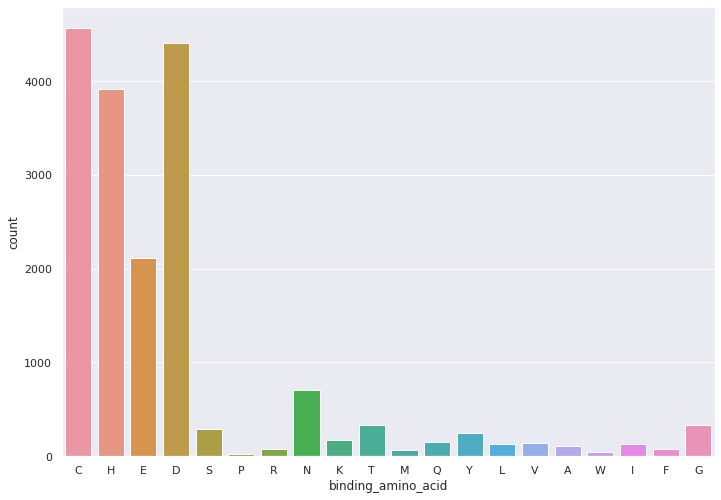

In [87]:
# plot for the previous counts
sns.countplot(x='binding_amino_acid', data=pos_train_df1)

The following amino acid are more likely to bind to metals than other amino acids with the following percentages:

C:    25.295128

D:    24.402815

H:    21.675996

E:    11.733082


In [90]:
# exploring the top binding metals for (C, D, H, E) amino acids with highest
list_amino_acids = []
temp = pos_train_df1[~pos_train_df1.binding_amino_acid.isin(list_amino_acids)]

#pos_train_df1[pos_train_df1['Binding Amino Acid'] in ]
temp = temp.groupby(['binding_amino_acid', 'metal_name']).count().sort_values(['id'], ascending=False)
temp = temp.drop(['Position','window_3','window_10'], axis=1).rename(columns={'id':'metal_counts'}).reset_index()
#temp['metal_counts'] = temp['metal_counts'] /temp['metal_counts'].abs().max()
temp

,binding_amino_acid,metal_name,metal_counts
0,C,Zn(2+),2771
1,H,Zn(2+),2034
2,D,Ca(2+),1952
3,D,Mg(2+),1058
4,C,[4Fe-4S] cluster,870
...,...,...,...
189,I,[4Fe-4S] cluster,1
190,Q,K(+),1
191,T,Ni(2+),1
192,K,Na(+),1


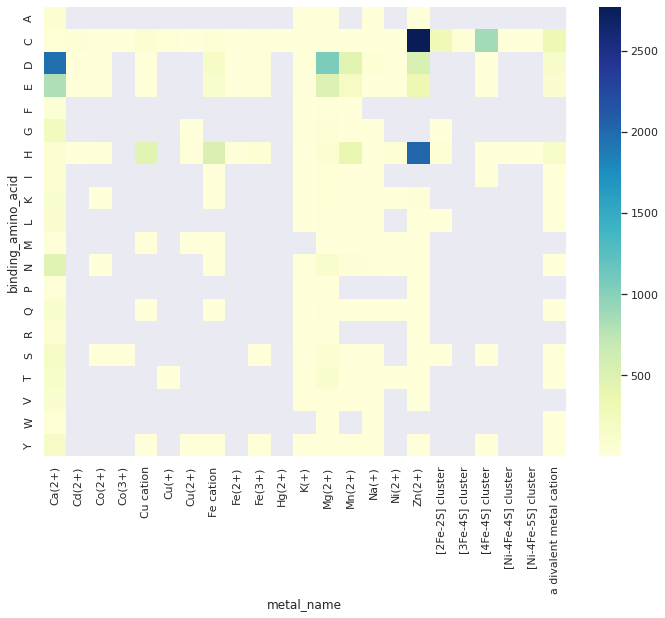

In [91]:
heatmap = temp.pivot("binding_amino_acid", "metal_name", "metal_counts")
ax = sns.heatmap(heatmap , cmap="YlGnBu")

The previous heatmap combines the correlation and how likely you find a certian amino acid binding to a certian metal. There are some interesting insights coming out of this heat map:
* Metals: Ca(2+), K(+), Mg(2+), Mn(+), Na(+), and Zn(2+) can bind to more than 90 percent of the different amino acids. 
* Metal: Ca(2+) binds to all amino acids with a higher frequancy on (D, E).
* Amino Acid: C binds to all metals on the spectrum with more frequancy with Zn(2+) and [Ni-4Fe-4S] cluster.
* Metal Hg(2+) only binds to amino acid C


In [93]:
pos_train_df1.head()

,id,metal_name,Position,binding_amino_acid,window_3,window_10
0,Q8INK9,Zn(2+),157,C,CARCNAH,RIRTEVRCARCNAHMGHVFED
1,Q8INK9,Zn(2+),96,C,CIVCHQD,YEKGVYQCIVCHQDLFSSETK
2,Q8INK9,Zn(2+),93,C,VYQCIVC,NKHYEKGVYQCIVCHQDLFSS
3,Q8INK9,Zn(2+),154,C,EVRCARC,HPERIRTEVRCARCNAHMGHV
4,P07327,Zn(2+),101,C,CGKCRIC,IPLAIPQCGKCRICKNPESNY
